In [1]:
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torchsummary import summary

In [2]:
tensor_transform = transforms.ToTensor()
dataset = datasets.CIFAR10(
    root="../data", train=True, download=True, transform=tensor_transform
)
loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=32, shuffle=True)

# 1

In [ ]:
# Convolutional Autoencoder
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )
    
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        latent = self.encoder(x)
        recon = self.decoder(latent)
        return recon, latent

In [ ]:
epochs = 20
outputs = []
losses = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Cuda Avalible")
model = autoencoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-8)
loss_function = nn.MSELoss()

Cuda Avalible


autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(32, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): Sigmoid()
  )
)

In [8]:
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    for images, _ in loader:
        images = images.to(device)

        recon, latent = model(images)
        loss = loss_function(recon, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        losses.append(loss.item())
    avg_loss = epoch_loss / len(loader)
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}")
    if epoch % 10 == 0:
        outputs.append((epoch, images[:8].detach().cpu(), recon[:8].detach().cpu(), latent[:8].detach().cpu()))

Epoch [1/20], Loss: 0.0005
Epoch [2/20], Loss: 0.0005
Epoch [3/20], Loss: 0.0005
Epoch [4/20], Loss: 0.0005
Epoch [5/20], Loss: 0.0004
Epoch [6/20], Loss: 0.0004
Epoch [7/20], Loss: 0.0004
Epoch [8/20], Loss: 0.0004
Epoch [9/20], Loss: 0.0004
Epoch [10/20], Loss: 0.0004
Epoch [11/20], Loss: 0.0004
Epoch [12/20], Loss: 0.0004
Epoch [13/20], Loss: 0.0004
Epoch [14/20], Loss: 0.0004
Epoch [15/20], Loss: 0.0004
Epoch [16/20], Loss: 0.0003
Epoch [17/20], Loss: 0.0003
Epoch [18/20], Loss: 0.0003
Epoch [19/20], Loss: 0.0003
Epoch [20/20], Loss: 0.0003


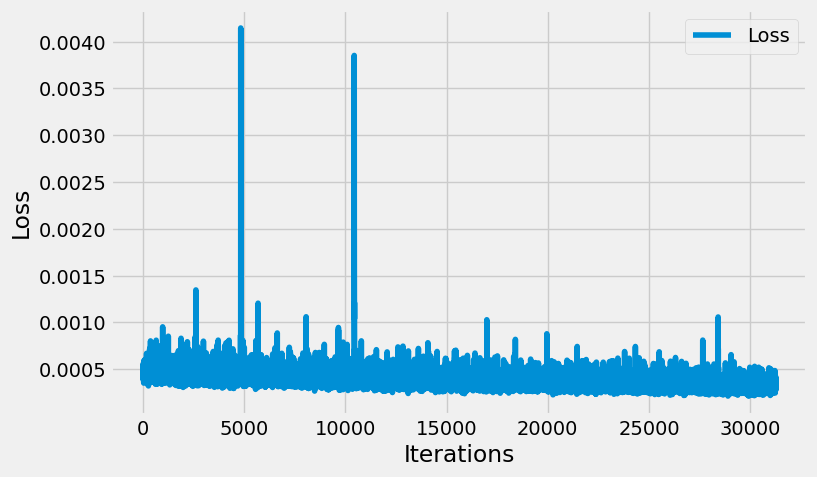

In [9]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 5))
plt.plot(losses, label="Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()

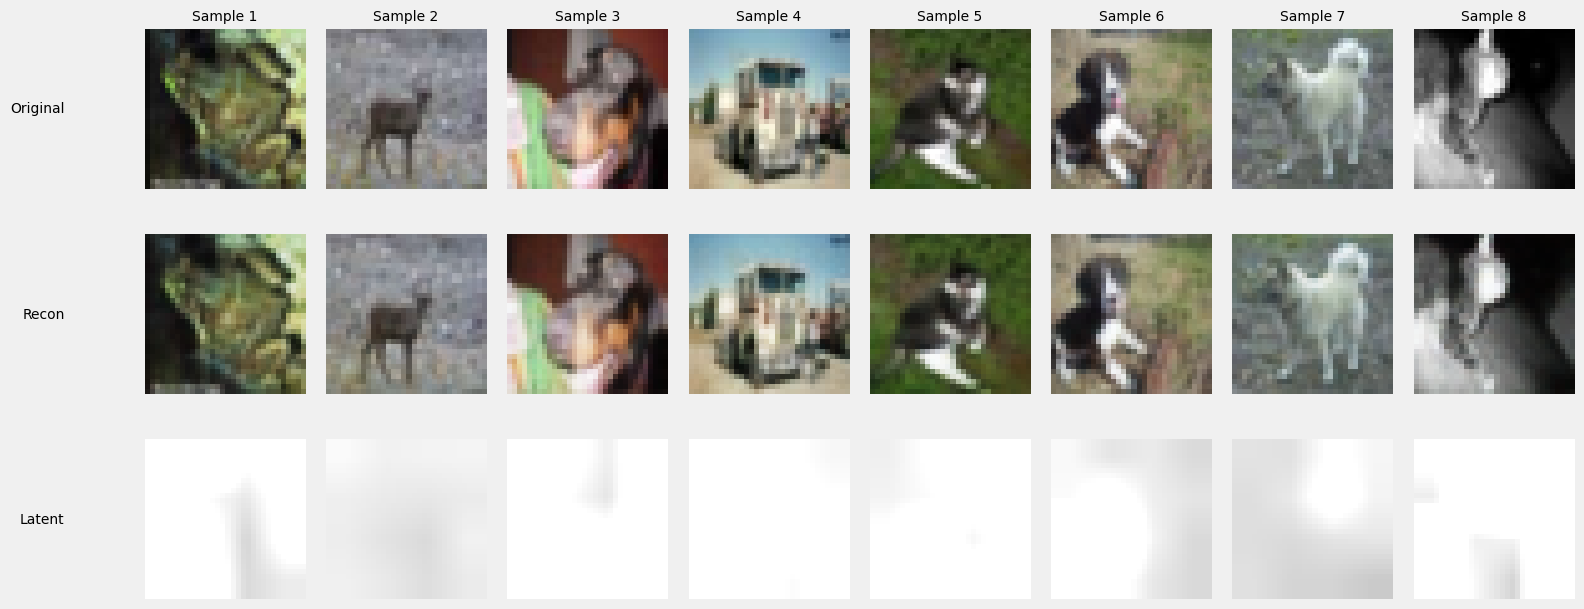

In [18]:
epoch_idx, original_imgs, recon_imgs, latents = outputs[-1]

latent_imgs = latents.mean(1, keepdim=True)  
latent_imgs = torch.nn.functional.interpolate(latent_imgs, size=(32, 32), mode='bilinear')
latent_imgs = latent_imgs.expand(-1, 3, -1, -1)  

image_sets = [
    ("Original", original_imgs),
    ("Recon", recon_imgs),
    ("Latent", latent_imgs)
]


cols = 8
rows = len(image_sets)
plt.figure(figsize=(2 * cols, 2.2 * rows))

for col in range(cols):
    for row, (title, img_batch) in enumerate(image_sets):
        ax = plt.subplot(rows, cols, row * cols + col + 1)
        img = img_batch[col].permute(1, 2, 0).numpy().clip(0, 1)
        ax.imshow(img)
        ax.axis('off')
        if row == 0:
            ax.set_title(f"Sample {col + 1}", fontsize=10)
        if col == 0:
            ax.text(-0.5, 0.5, title, fontsize=10, va='center', ha='right',
                    transform=ax.transAxes)

plt.tight_layout()
plt.savefig("../output/v7/Conv_Autoencoder.png")
plt.show()


In [17]:
torch.save(model.state_dict(), "../output/v7/Conv_Autoencoder_weight.pth")
torch.save(model, "../output/Conv_Autoencoder.pth")
print("Saved")

Saved


# 2

In [7]:
class Encoder(nn.Module):
    def __init__(self, latent_dim=10):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),  
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),  
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1),  
            nn.ReLU(),
        )
        self.fc = nn.Linear(128 * 4 * 4, latent_dim)

    def forward(self, x):
        x = self.conv(x)
        # flatten latent
        x = x.view(x.size(0), -1)
        return self.fc(x)


class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 128 * 4 * 4)
        self.deconv = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),  
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),  
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1),   
            nn.Sigmoid(),  
        )

    def forward(self, z):
        z = self.fc(z)
        z = z.view(z.size(0), 128, 4, 4)
        return self.deconv(z)


class mrl_autoencoder(nn.Module):
    def __init__(self, latent_dim=10, trunc_dim=5):
        super().__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder_5 = Decoder(trunc_dim)
        self.decoder_10 = Decoder(latent_dim)

    def forward(self, x):
        z = self.encoder(x)           
        z_5 = z[:, :5]                
        recon_5 = self.decoder_5(z_5)
        recon_10 = self.decoder_10(z)
        return recon_5, recon_10

In [8]:
def matryoshka_loss(x, recon_5, recon_10, alpha=0.5):
    loss_5 = F.mse_loss(recon_5, x)
    loss_10 = F.mse_loss(recon_10, x)
    return alpha * loss_5 + (1 - alpha) * loss_10

epochs = 20
outputs = []
losses = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Cuda Avalible")
model = mrl_autoencoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

Cuda Avalible


In [9]:
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    for images, _ in loader:
        images = images.to(device)

        recon_5, recon_10 = model(images)
        loss = matryoshka_loss(images, recon_5=recon_5, recon_10=recon_10)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        losses.append(loss.item())
    avg_loss = epoch_loss / len(loader)
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}")
    if epoch % 10 == 0:
        outputs.append((epoch, images[:8].detach().cpu(), recon_5[:8].detach().cpu(), recon_10[:8].detach().cpu()))

Epoch [1/20], Loss: 0.0279
Epoch [2/20], Loss: 0.0244
Epoch [3/20], Loss: 0.0241
Epoch [4/20], Loss: 0.0240
Epoch [5/20], Loss: 0.0238
Epoch [6/20], Loss: 0.0237
Epoch [7/20], Loss: 0.0237
Epoch [8/20], Loss: 0.0236
Epoch [9/20], Loss: 0.0235
Epoch [10/20], Loss: 0.0235
Epoch [11/20], Loss: 0.0234
Epoch [12/20], Loss: 0.0234
Epoch [13/20], Loss: 0.0233
Epoch [14/20], Loss: 0.0233
Epoch [15/20], Loss: 0.0233
Epoch [16/20], Loss: 0.0232
Epoch [17/20], Loss: 0.0232
Epoch [18/20], Loss: 0.0232
Epoch [19/20], Loss: 0.0231
Epoch [20/20], Loss: 0.0231


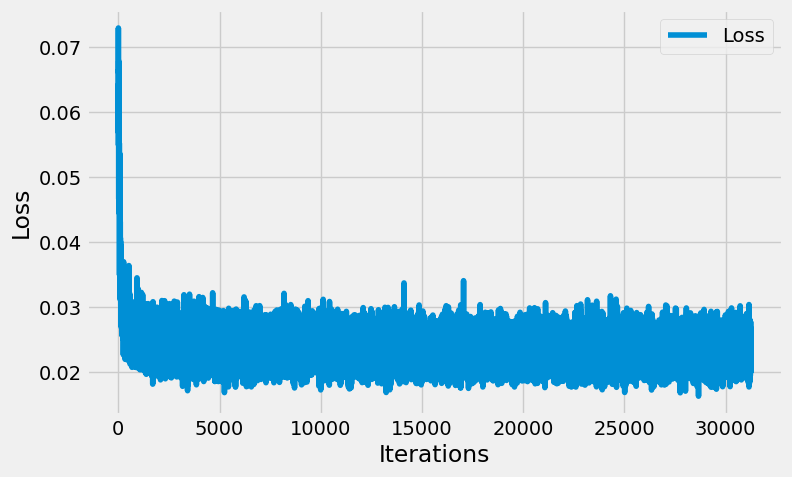

In [13]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 5))
plt.plot(losses, label="Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()

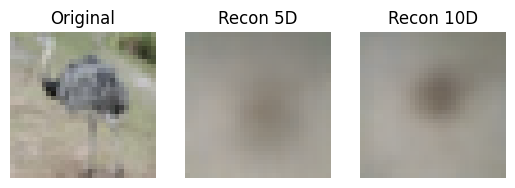

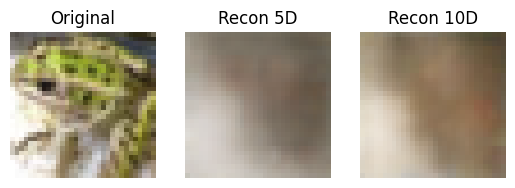

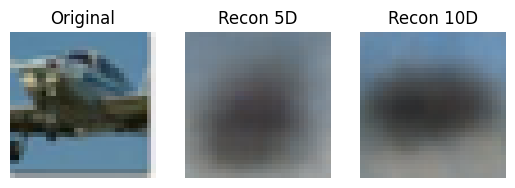

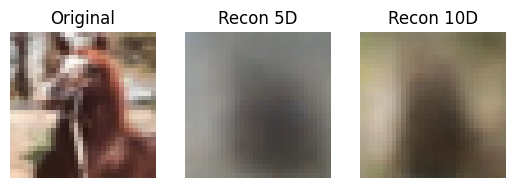

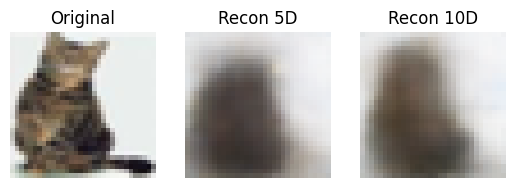

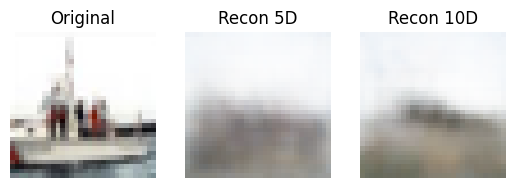

In [10]:
def show_reconstructions(model, data_loader):
    model.eval()
    with torch.no_grad():
        x, _ = next(iter(data_loader))
        x = x.to(device)
        recon_5, recon_10 = model(x)
        
        for i in range(6):
            fig, axs = plt.subplots(1, 3)
            axs[0].imshow(x[i].permute(1, 2, 0).cpu())
            axs[0].set_title("Original")
            axs[1].imshow(recon_5[i].permute(1, 2, 0).cpu())
            axs[1].set_title("Recon 5D")
            axs[2].imshow(recon_10[i].permute(1, 2, 0).cpu())
            axs[2].set_title("Recon 10D")
            for ax in axs:
                ax.axis('off')
            plt.show()

show_reconstructions(model, loader)

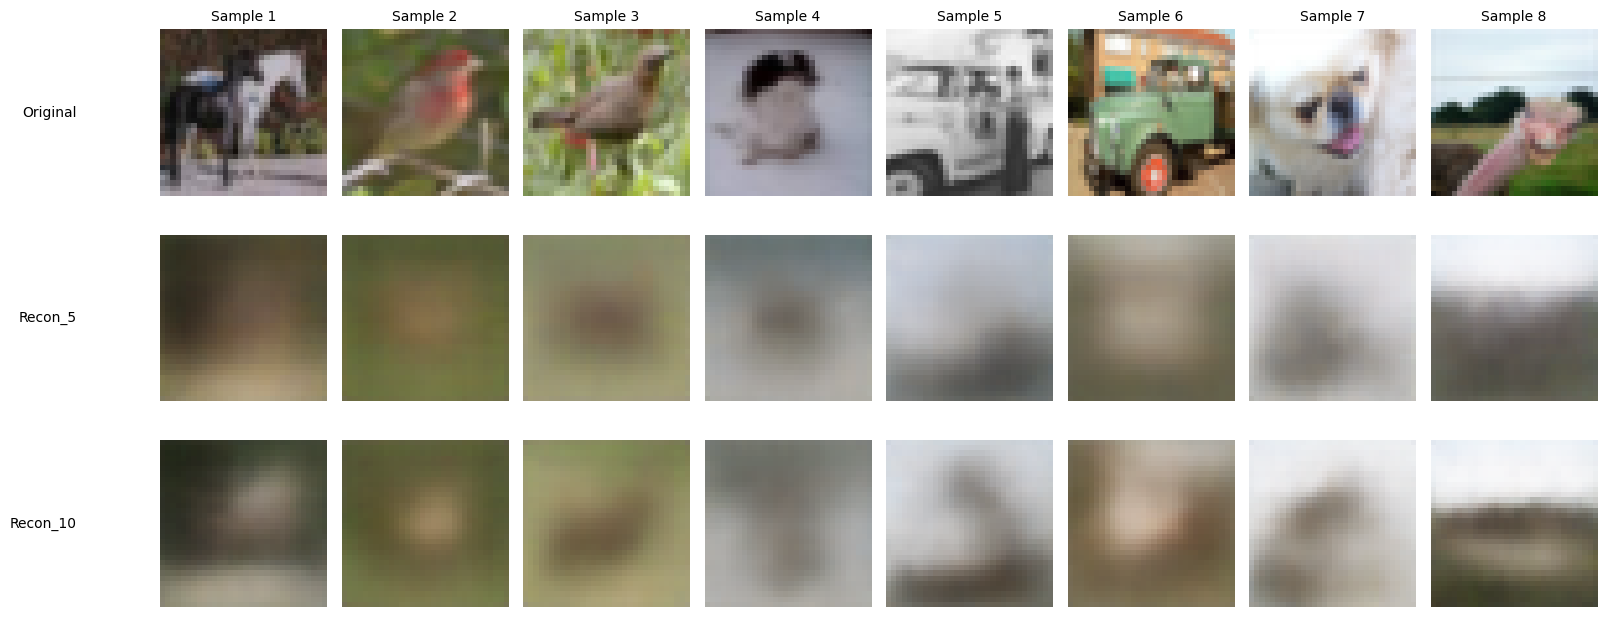

In [12]:
epoch_idx, original_imgs, recon_5_imgs, recon_10_imgs = outputs[-1]

image_sets = [
    ("Original", original_imgs),
    ("Recon_5", recon_5_imgs),
    ("Recon_10", recon_10_imgs),
]


cols = 8
rows = len(image_sets)
plt.figure(figsize=(2 * cols, 2.2 * rows))

for col in range(cols):
    for row, (title, img_batch) in enumerate(image_sets):
        ax = plt.subplot(rows, cols, row * cols + col + 1)
        img = img_batch[col].permute(1, 2, 0).numpy().clip(0, 1)
        ax.imshow(img)
        ax.axis('off')
        if row == 0:
            ax.set_title(f"Sample {col + 1}", fontsize=10)
        if col == 0:
            ax.text(-0.5, 0.5, title, fontsize=10, va='center', ha='right',
                    transform=ax.transAxes)

plt.tight_layout()
plt.savefig("../output/v7/mrl_autoencoder.png")
plt.show()


# 3

In [26]:
# Convolutional Autoencoder
class test_7_1(nn.Module):
    def __init__(self):
        super(test_7_1, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )
    
        self.decoder_full = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

        self.decoder_sub = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        latent = self.encoder(x)
        recon = self.decoder_full(latent)
        latent_sub = latent[:, :64, :, :]
        recon_sub = self.decoder_sub(latent_sub)
        return recon, recon_sub

In [27]:
model = test_7_1().to("cuda")
summary(model, input_size=(3, 32, 32), device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             896
              ReLU-2           [-1, 32, 16, 16]               0
            Conv2d-3             [-1, 64, 8, 8]          18,496
              ReLU-4             [-1, 64, 8, 8]               0
            Conv2d-5            [-1, 128, 4, 4]          73,856
              ReLU-6            [-1, 128, 4, 4]               0
   ConvTranspose2d-7             [-1, 64, 8, 8]          73,792
              ReLU-8             [-1, 64, 8, 8]               0
   ConvTranspose2d-9           [-1, 32, 16, 16]          18,464
             ReLU-10           [-1, 32, 16, 16]               0
  ConvTranspose2d-11            [-1, 3, 32, 32]             867
          Sigmoid-12            [-1, 3, 32, 32]               0
  ConvTranspose2d-13             [-1, 32, 8, 8]          18,464
             ReLU-14             [-1, 3

In [31]:
epochs = 20
outputs = []
losses = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Cuda Avalible")
model = test_7_1().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-8)
loss_function = nn.MSELoss()

Cuda Avalible


In [ ]:
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    for images, _ in loader:
        images = images.to(device)

        recon, sub_recon = model(images)
        loss_full = loss_function(recon, images)
        loss_sub = loss_function(sub_recon, images)
        loss = (loss_full + loss_sub) / 2

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        losses.append(loss.item())
    avg_loss = epoch_loss / len(loader)
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}")
    if epoch % 10 == 0:
        outputs.append((epoch, images[:8].detach().cpu(), recon[:8].detach().cpu(), sub_recon[:8].detach().cpu()))

epoch_idx, original_imgs, recon_imgs, sub_recon_imgs = outputs[-1]

image_sets = [
    ("Original", original_imgs),
    ("Recon", recon_imgs),
    ("Sub Recon", sub_recon_imgs)
]


cols = 8
rows = len(image_sets)
plt.figure(figsize=(2 * cols, 2.2 * rows))

for col in range(cols):
    for row, (title, img_batch) in enumerate(image_sets):
        ax = plt.subplot(rows, cols, row * cols + col + 1)
        img = img_batch[col].permute(1, 2, 0).numpy().clip(0, 1)
        ax.imshow(img)
        ax.axis('off')
        if row == 0:
            ax.set_title(f"Sample {col + 1}", fontsize=10)
        if col == 0:
            ax.text(-0.5, 0.5, title, fontsize=10, va='center', ha='right',
                    transform=ax.transAxes)

plt.tight_layout()
plt.show()


Epoch [1/20], Loss: 0.0096
Epoch [2/20], Loss: 0.0039
Epoch [3/20], Loss: 0.0026
Epoch [4/20], Loss: 0.0021
Epoch [5/20], Loss: 0.0018
Epoch [6/20], Loss: 0.0016
Epoch [7/20], Loss: 0.0014
Epoch [8/20], Loss: 0.0013
Epoch [9/20], Loss: 0.0012
Epoch [10/20], Loss: 0.0011
Epoch [11/20], Loss: 0.0010
Epoch [12/20], Loss: 0.0010
Epoch [13/20], Loss: 0.0009
Epoch [14/20], Loss: 0.0009
Epoch [15/20], Loss: 0.0008
Epoch [16/20], Loss: 0.0008
Epoch [17/20], Loss: 0.0008
Epoch [18/20], Loss: 0.0008
Epoch [19/20], Loss: 0.0007
Epoch [20/20], Loss: 0.0007


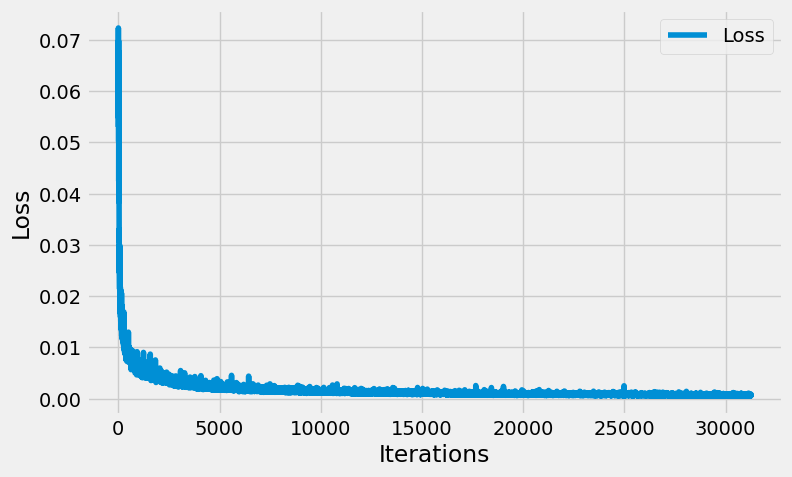

In [19]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 5))
plt.plot(losses, label="Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()

Epoch [1/20], Loss: 0.0110
Epoch [2/20], Loss: 0.0045
Epoch [3/20], Loss: 0.0033
Epoch [4/20], Loss: 0.0026
Epoch [5/20], Loss: 0.0022
Epoch [6/20], Loss: 0.0019
Epoch [7/20], Loss: 0.0018
Epoch [8/20], Loss: 0.0016
Epoch [9/20], Loss: 0.0015
Epoch [10/20], Loss: 0.0015
Epoch [11/20], Loss: 0.0014
Epoch [12/20], Loss: 0.0013
Epoch [13/20], Loss: 0.0013
Epoch [14/20], Loss: 0.0012
Epoch [15/20], Loss: 0.0012
Epoch [16/20], Loss: 0.0011
Epoch [17/20], Loss: 0.0011
Epoch [18/20], Loss: 0.0010
Epoch [19/20], Loss: 0.0010
Epoch [20/20], Loss: 0.0010


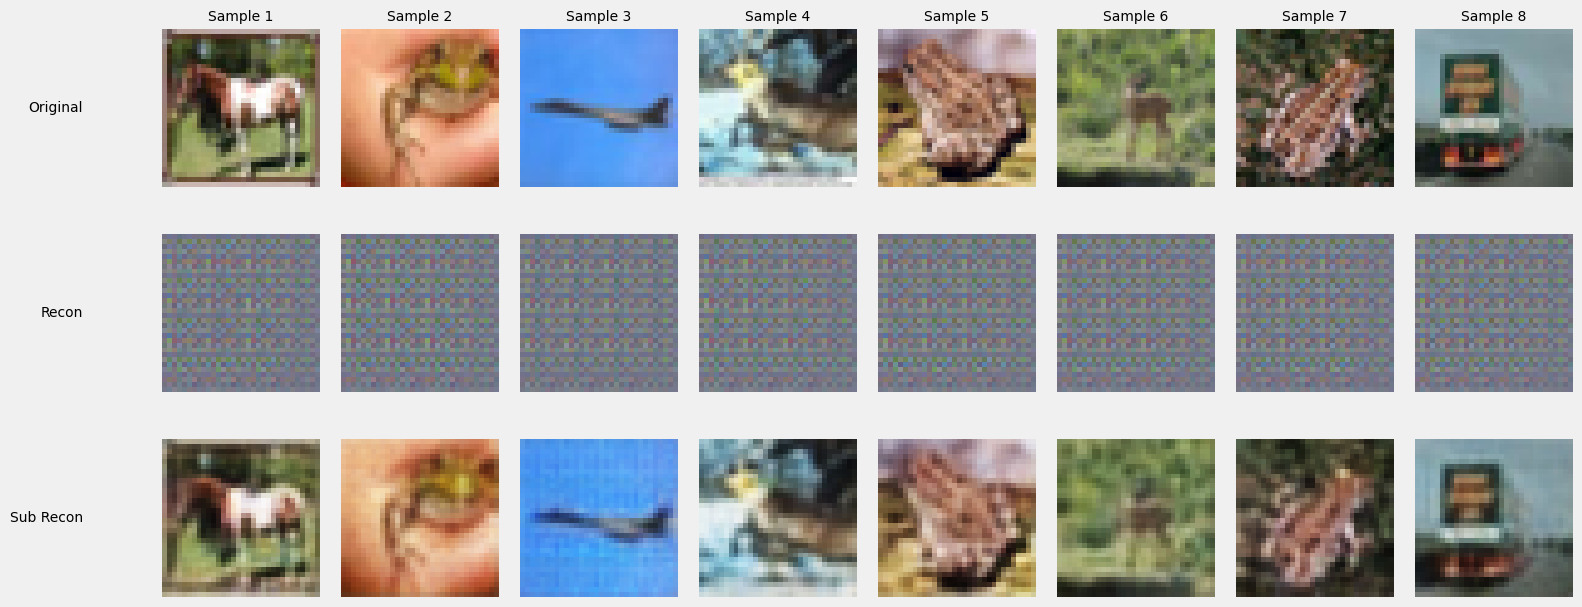

In [25]:
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    for images, _ in loader:
        images = images.to(device)

        recon, sub_recon = model(images)
        # loss_full = loss_function(recon, images)
        loss_sub = loss_function(sub_recon, images)
        loss = loss_sub

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        losses.append(loss.item())
    avg_loss = epoch_loss / len(loader)
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}")
    if epoch % 10 == 0:
        outputs.append((epoch, images[:8].detach().cpu(), recon[:8].detach().cpu(), sub_recon[:8].detach().cpu()))

epoch_idx, original_imgs, recon_imgs, sub_recon_imgs = outputs[-1]

image_sets = [
    ("Original", original_imgs),
    ("Recon", recon_imgs),
    ("Sub Recon", sub_recon_imgs)
]


cols = 8
rows = len(image_sets)
plt.figure(figsize=(2 * cols, 2.2 * rows))

for col in range(cols):
    for row, (title, img_batch) in enumerate(image_sets):
        ax = plt.subplot(rows, cols, row * cols + col + 1)
        img = img_batch[col].permute(1, 2, 0).numpy().clip(0, 1)
        ax.imshow(img)
        ax.axis('off')
        if row == 0:
            ax.set_title(f"Sample {col + 1}", fontsize=10)
        if col == 0:
            ax.text(-0.5, 0.5, title, fontsize=10, va='center', ha='right',
                    transform=ax.transAxes)

plt.tight_layout()
plt.show()


In [32]:
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    for images, _ in loader:
        images = images.to(device)

        recon, sub_recon = model(images)
        loss_full = loss_function(recon, images)
        # loss_sub = loss_function(sub_recon, images)
        loss = loss_full

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        losses.append(loss.item())
    avg_loss = epoch_loss / len(loader)
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}")
    if epoch % 10 == 0:
        outputs.append((epoch, images[:8].detach().cpu(), recon[:8].detach().cpu(), sub_recon[:8].detach().cpu()))

epoch_idx, original_imgs, recon_imgs, sub_recon_imgs = outputs[-1]

image_sets = [
    ("Original", original_imgs),
    ("Recon", recon_imgs),
    ("Sub Recon", sub_recon_imgs)
]


cols = 8
rows = len(image_sets)
plt.figure(figsize=(2 * cols, 2.2 * rows))

for col in range(cols):
    for row, (title, img_batch) in enumerate(image_sets):
        ax = plt.subplot(rows, cols, row * cols + col + 1)
        img = img_batch[col].permute(1, 2, 0).numpy().clip(0, 1)
        ax.imshow(img)
        ax.axis('off')
        if row == 0:
            ax.set_title(f"Sample {col + 1}", fontsize=10)
        if col == 0:
            ax.text(-0.5, 0.5, title, fontsize=10, va='center', ha='right',
                    transform=ax.transAxes)

plt.tight_layout()
plt.show()


Epoch [1/20], Loss: 0.0081
Epoch [2/20], Loss: 0.0030
Epoch [3/20], Loss: 0.0021


KeyboardInterrupt: 

# 4

In [3]:
# Convolutional Autoencoder
class test_7_2(nn.Module):
    def __init__(self):
        super(test_7_2, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )
    
        self.decoder_full = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

        self.decoder_sub = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        latent = self.encoder(x)
        recon_full = self.decoder_full(latent)
        latent_sub = latent[:, :64, :, :]
        recon_sub = self.decoder_sub(latent_sub)
        recon_comb = ((recon_sub * 3) + (recon_full)) / 4
        return recon_full, recon_sub, recon_comb

In [4]:
model = test_7_2()

# Fixed encoder
for param in model.encoder.parameters():
    param.requires_grad = False

model = model.to("cuda")
summary(model, input_size=(3, 32, 32), device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             896
              ReLU-2           [-1, 32, 16, 16]               0
            Conv2d-3             [-1, 64, 8, 8]          18,496
              ReLU-4             [-1, 64, 8, 8]               0
            Conv2d-5            [-1, 128, 4, 4]          73,856
              ReLU-6            [-1, 128, 4, 4]               0
   ConvTranspose2d-7             [-1, 64, 8, 8]          73,792
              ReLU-8             [-1, 64, 8, 8]               0
   ConvTranspose2d-9           [-1, 32, 16, 16]          18,464
             ReLU-10           [-1, 32, 16, 16]               0
  ConvTranspose2d-11            [-1, 3, 32, 32]             867
          Sigmoid-12            [-1, 3, 32, 32]               0
  ConvTranspose2d-13             [-1, 32, 8, 8]          18,464
             ReLU-14             [-1, 3

In [4]:
model = test_7_2()

# Fixed encoder
for param in model.decoder_full.parameters():
    param.requires_grad = False
for param in model.decoder_sub.parameters():
    param.requires_grad = False

model = model.to("cuda")
summary(model, input_size=(3, 32, 32), device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             896
              ReLU-2           [-1, 32, 16, 16]               0
            Conv2d-3             [-1, 64, 8, 8]          18,496
              ReLU-4             [-1, 64, 8, 8]               0
            Conv2d-5            [-1, 128, 4, 4]          73,856
              ReLU-6            [-1, 128, 4, 4]               0
   ConvTranspose2d-7             [-1, 64, 8, 8]          73,792
              ReLU-8             [-1, 64, 8, 8]               0
   ConvTranspose2d-9           [-1, 32, 16, 16]          18,464
             ReLU-10           [-1, 32, 16, 16]               0
  ConvTranspose2d-11            [-1, 3, 32, 32]             867
          Sigmoid-12            [-1, 3, 32, 32]               0
  ConvTranspose2d-13             [-1, 32, 8, 8]          18,464
             ReLU-14             [-1, 3

Epoch [1/20], Loss: 0.0585
Epoch [2/20], Loss: 0.0568
Epoch [3/20], Loss: 0.0565
Epoch [4/20], Loss: 0.0564
Epoch [5/20], Loss: 0.0563
Epoch [6/20], Loss: 0.0562
Epoch [7/20], Loss: 0.0562
Epoch [8/20], Loss: 0.0562
Epoch [9/20], Loss: 0.0562
Epoch [10/20], Loss: 0.0561
Epoch [11/20], Loss: 0.0561
Epoch [12/20], Loss: 0.0561
Epoch [13/20], Loss: 0.0561
Epoch [14/20], Loss: 0.0561
Epoch [15/20], Loss: 0.0561
Epoch [16/20], Loss: 0.0561
Epoch [17/20], Loss: 0.0561
Epoch [18/20], Loss: 0.0561
Epoch [19/20], Loss: 0.0561
Epoch [20/20], Loss: 0.0561


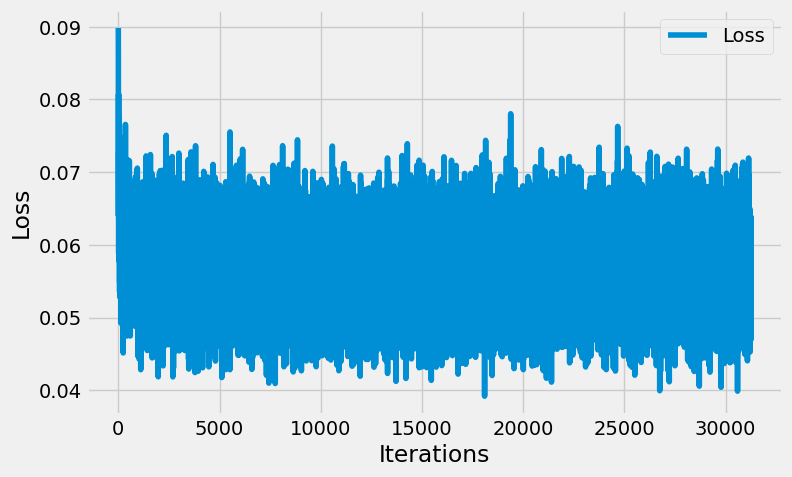

In [7]:
epochs = 20
outputs = []
losses = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-8)
loss_function = nn.MSELoss()

for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    for images, _ in loader:
        images = images.to(device)

        recon_full, recon_sub, recon_comb = model(images)
        loss_full = loss_function(recon_full, images)
        loss_sub = loss_function(recon_sub, images)
        loss_comb = loss_function(recon_comb, images)
        loss = loss_full

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        losses.append(loss.item())
    avg_loss = epoch_loss / len(loader)
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}")
    if epoch % 10 == 0:
        outputs.append((epoch, images[:8].detach().cpu(), recon_full[:8].detach().cpu(), recon_sub[:8].detach().cpu(), recon_comb[:8].detach().cpu()))

plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 5))
plt.plot(losses, label="Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()

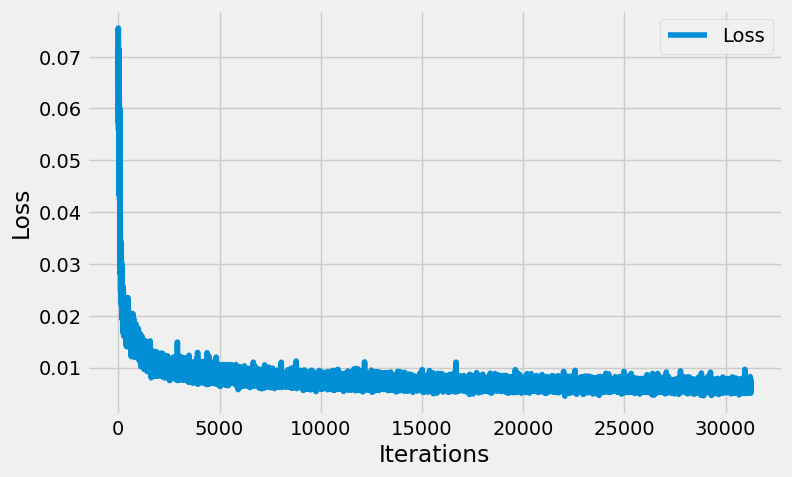

In [ ]:
# Freeze encoder
plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 5))
plt.plot(losses, label="Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()

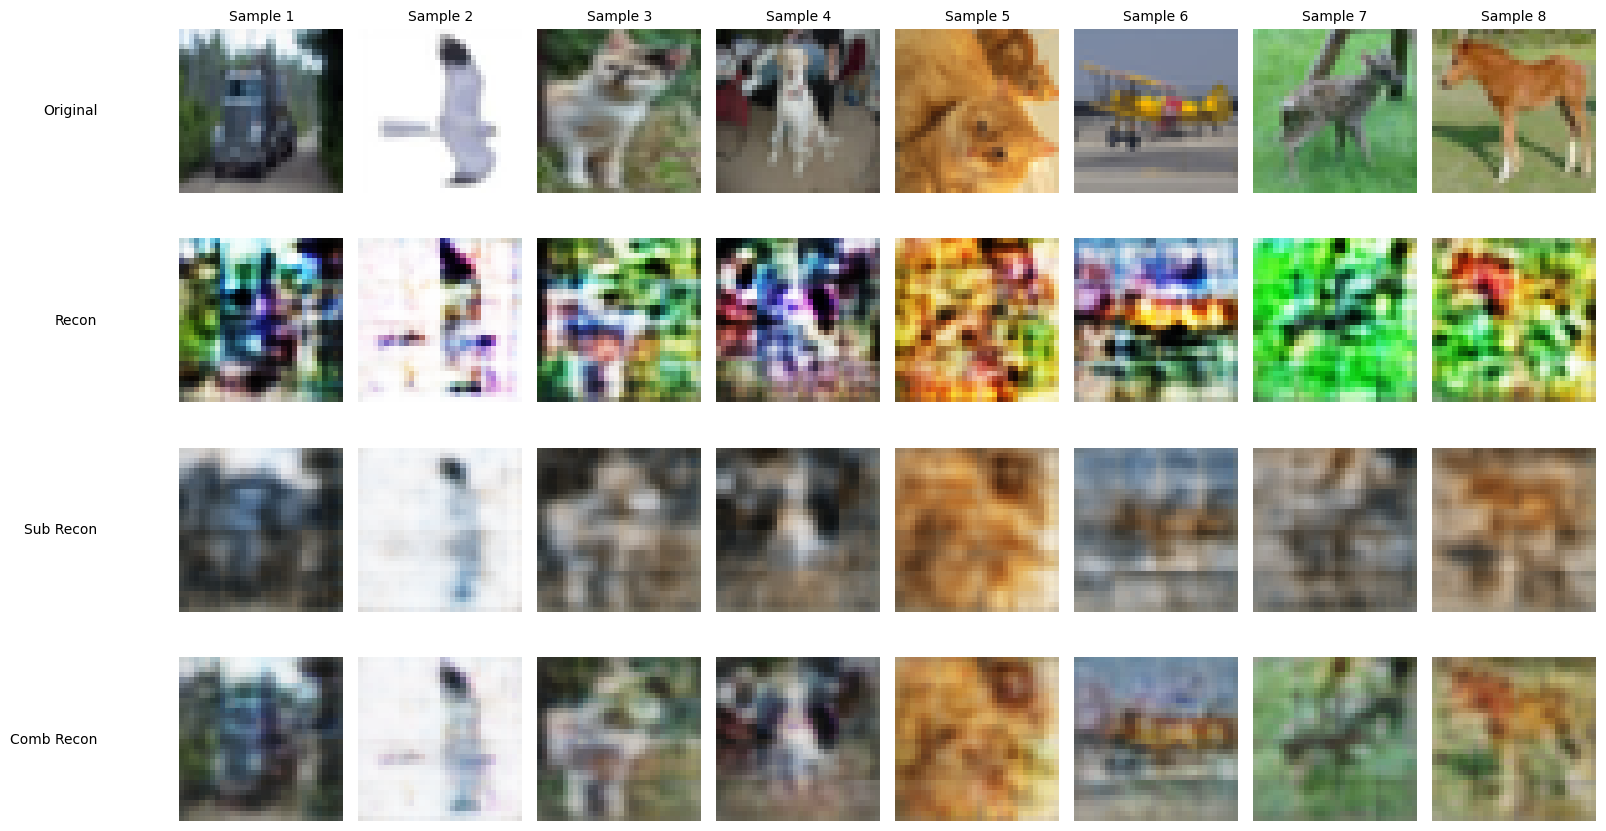

In [ ]:
# Freeze Encoder
epoch_idx, original_imgs, recon_imgs, sub_recon_imgs, recon_comb_imgs = outputs[-1]

image_sets = [
    ("Original", original_imgs),
    ("Recon", recon_imgs),
    ("Sub Recon", sub_recon_imgs),
    ("Comb Recon", recon_comb_imgs)
]


cols = 8
rows = len(image_sets)
plt.figure(figsize=(2 * cols, 2.2 * rows))

for col in range(cols):
    for row, (title, img_batch) in enumerate(image_sets):
        ax = plt.subplot(rows, cols, row * cols + col + 1)
        img = img_batch[col].permute(1, 2, 0).numpy().clip(0, 1)
        ax.imshow(img)
        ax.axis('off')
        if row == 0:
            ax.set_title(f"Sample {col + 1}", fontsize=10)
        if col == 0:
            ax.text(-0.5, 0.5, title, fontsize=10, va='center', ha='right',
                    transform=ax.transAxes)

plt.tight_layout()
plt.show()

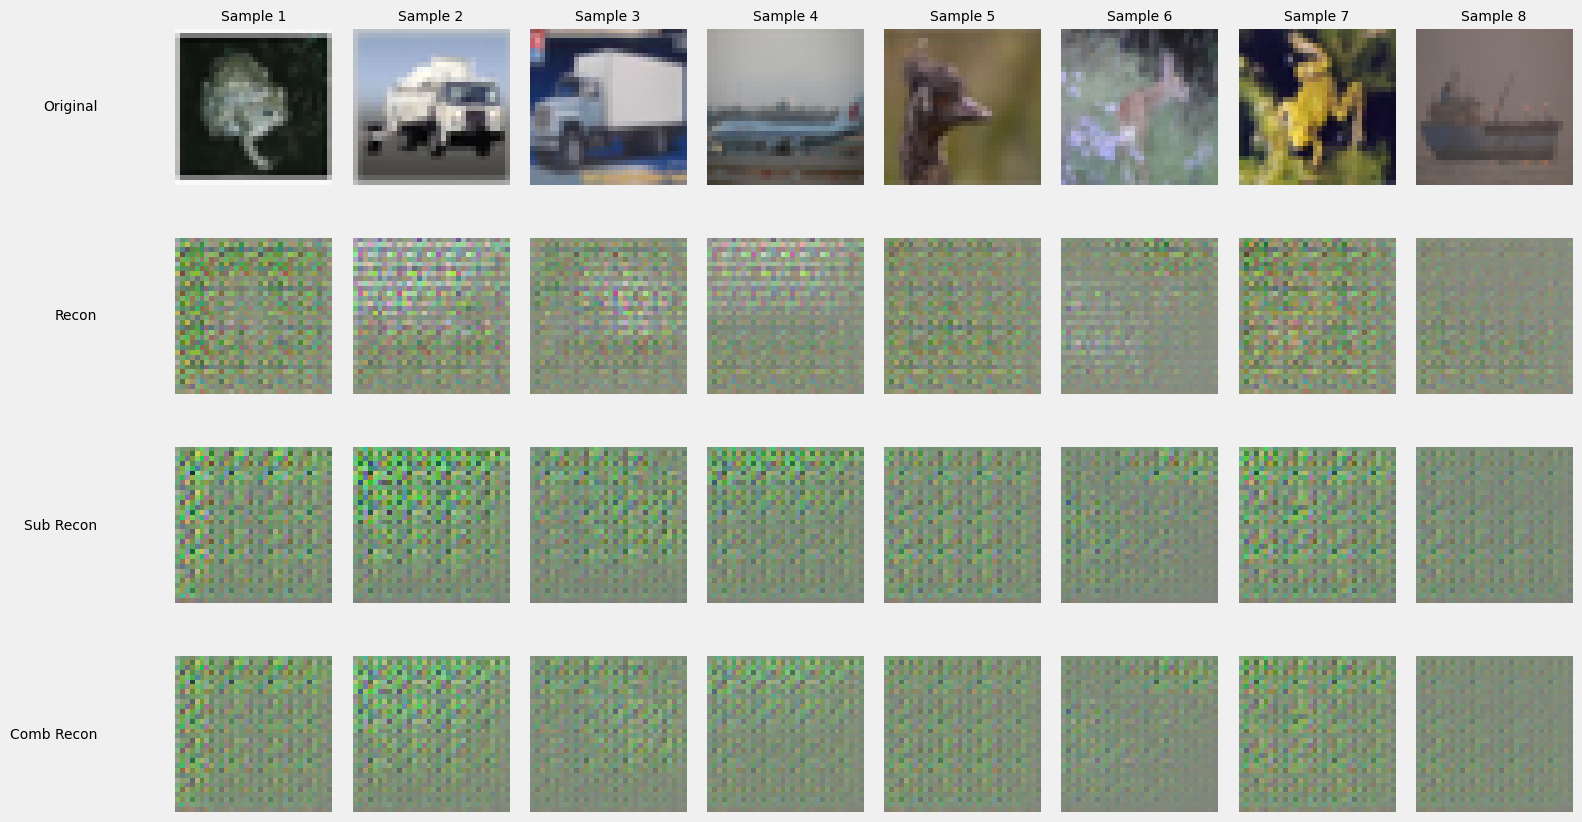

In [8]:
# Freeze Decoder
epoch_idx, original_imgs, recon_imgs, sub_recon_imgs, recon_comb_imgs = outputs[-1]

image_sets = [
    ("Original", original_imgs),
    ("Recon", recon_imgs),
    ("Sub Recon", sub_recon_imgs),
    ("Comb Recon", recon_comb_imgs)
]


cols = 8
rows = len(image_sets)
plt.figure(figsize=(2 * cols, 2.2 * rows))

for col in range(cols):
    for row, (title, img_batch) in enumerate(image_sets):
        ax = plt.subplot(rows, cols, row * cols + col + 1)
        img = img_batch[col].permute(1, 2, 0).numpy().clip(0, 1)
        ax.imshow(img)
        ax.axis('off')
        if row == 0:
            ax.set_title(f"Sample {col + 1}", fontsize=10)
        if col == 0:
            ax.text(-0.5, 0.5, title, fontsize=10, va='center', ha='right',
                    transform=ax.transAxes)

plt.tight_layout()
plt.show()